## BAYESIAN:
MAXIMIZE POSTERIOR

MCMC: P(d|theta) = P(theta|d)P(theta) / P(d)

FOR MODEL COMPARISION FIND P(d)

P(d) = $\int$ P(d|theta)P(theta)dtheta

new NESTED SAMPLING to find P(d)



dynesty and nestle for nested sampling

dynesty

    PRIOR - (emcee we define  log prior output is 0 or $-\inf$)

        in dynesty: a UNIFORM distribution between [0, 1) is transformed to the parameter space of our originl prior.

            We define a function defining the tranform between the parameterisation in the unit hypercube
            to the true parameters.
            for example if prior is UNIFORM between -10, 10:
                then the prior function gives an output between -10, and 10 for input 

    LIKELIHOOD - (same as emcee log likelihood)

ndtri = inverse of gaussian function

#### Read up (Beyond MCMC)
        Particle suorm optimisation
        Variational Inference
        Simulated annealing

In [27]:
import numpy as np
from scipy.special import ndtri
from scipy.stats import norm, gaussian_kde
import dynesty
import corner

In [28]:
dynesty.__version__

'2.1.0'

In [87]:
M = 50
xmin = 0.
xmax = 10.
stepsize = (xmax - xmin) / M
x = np.arange(xmin, xmax, stepsize)

# define the model function
def straight_line(x, m, c, sin=False):
    """
    A straight line model: y = m*x + c
    
    Args:
        x (list): a set of abscissa points at which the model is defined
        m (float): the gradient of the line
        c (float): the y-intercept of the line
    """
    if sin == True:
        return m*np.sin(x) + c*np.cos(x)

    return m * x + c

# seed our random number generator, so we have reproducible data
np.random.seed(sum([ord(v) for v in 'samplers']))

# create the data - the model plus Gaussian noise
sigma = 2.0  # standard deviation of the noise
m = 3.5
c = 1.2
data = straight_line(x, m, c) + np.random.normal(scale=sigma, size=M)

In [108]:
def prior_transform(theta):
    """
    A function defining the tranform between the parameterisation in the unit hypercube
    to the true parameters.

    Args:
        theta (tuple): a tuple containing the parameters.
        
    Returns:
        tuple: a new tuple or array with the transformed parameters.
    """

    mprime, cprime = theta # unpack the parameters (in their unit hypercube form)

    cmin = -10.  # lower bound on uniform prior on c
    cmax = 10.   # upper bound on uniform prior on c

    mmu = 0.     # mean of Gaussian prior on m
    msigma = 10. # standard deviation of Gaussian prior on m

    m = mmu + msigma*ndtri(mprime) # convert back to m
    c = cprime*(cmax-cmin) + cmin  # convert back to c

    return (m, c)


# set the natural logarithm of 2pi, so that it doesn't have to be recalculated
LN2PI = np.log(2. * np.pi)
LNSIGMA = np.log(sigma) # natural log of the data noise standard deviation


def loglikelihood_dynesty(theta):
    """
    The log-likelihood function.
    """

    m, c = theta # unpack the parameters

    # normalisation
    norm = -0.5 * M * LN2PI - M * LNSIGMA

    # chi-squared (data, sigma and x are global variables defined early on in this notebook)
    chisq = np.sum(((data-straight_line(x, m, c))/sigma)**2)

    return norm - 0.5 * chisq

In [109]:
nlive = 1024      # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 2         # two parameters
sample = 'unif'   # uniform sampling
tol = 0.1         # the stopping criterion

from dynesty import NestedSampler

sampler = NestedSampler(loglikelihood_dynesty, prior_transform, ndims,
                        bound=bound, sample=sample, nlive=nlive)

# t0 = time()
sampler.run_nested(dlogz=tol, print_progress=False) # don't output progress bar
# t1 = time()
res = sampler.results # get results dictionary from sampler

logZdynesty = res.logz[-1]        # value of logZ
logZerrdynesty = res.logzerr[-1]  # estimate of the statistcal uncertainty on logZ

print("log(Z) = {} ± {}".format(logZdynesty, logZerrdynesty))

log(Z) = -116.61274350891692 ± 0.10571679714220512


In [110]:
print(res.summary())

Summary
nlive: 1024
niter: 10550
ncall: 48640
eff(%): 23.795
logz: -116.613 +/-  0.106
None


In [111]:
def plotposts(samples, **kwargs):
    """
    Function to plot posteriors using corner.py and scipy's gaussian KDE function.
    """
    if "truths" not in kwargs:
        kwargs["truths"] = [m, c]

    fig = corner.corner(samples, labels=[r'$m$', r'$c$'], hist_kwargs={'density': True}, **kwargs)

    # plot KDE smoothed version of distributions
    for axidx, samps in zip([0, 3], samples.T):
        kde = gaussian_kde(samps)
        xvals = fig.axes[axidx].get_xlim()
        xvals = np.linspace(xvals[0], xvals[1], 100)
        fig.axes[axidx].plot(xvals, kde(xvals), color='firebrick')

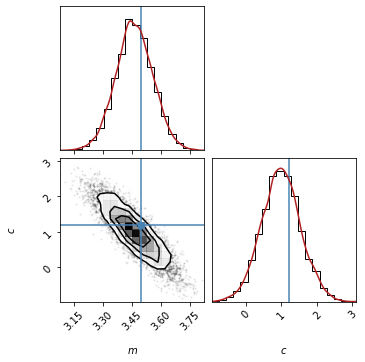

In [112]:
from dynesty.utils import resample_equal

# draw posterior samples
weights = np.exp(res['logwt'] - res['logz'][-1])
samples_dynesty = resample_equal(res.samples, weights)
plotposts(samples_dynesty)

In [113]:
# Dynamicsampler
from dynesty import DynamicNestedSampler
dsampler = DynamicNestedSampler(loglikelihood_dynesty, prior_transform, ndims)
dsampler.run_nested(nlive_init=nlive, print_progress=False)
res = dsampler.results # get results dictionary from sampler

logZdynesty = res.logz[-1]        # value of logZ
logZerrdynesty = res.logzerr[-1]  # estimate of the statistcal uncertainty on logZ

print("log(Z) = {} ± {}".format(logZdynesty, logZerrdynesty))

weights = np.exp(res['logwt'] - res['logz'][-1])
samples_dynesty = resample_equal(res.samples, weights) #GIVES POSTERIOR LIKE STUFF

log(Z) = -116.80548868101059 ± 0.05979861706780347


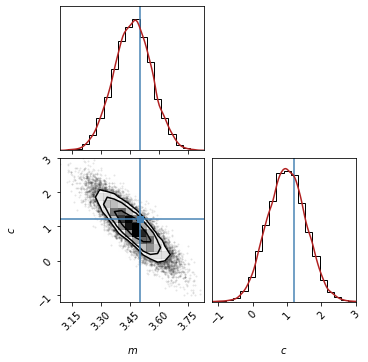

In [114]:
plotposts(samples_dynesty)

In [115]:
import matplotlib.pyplot as plt

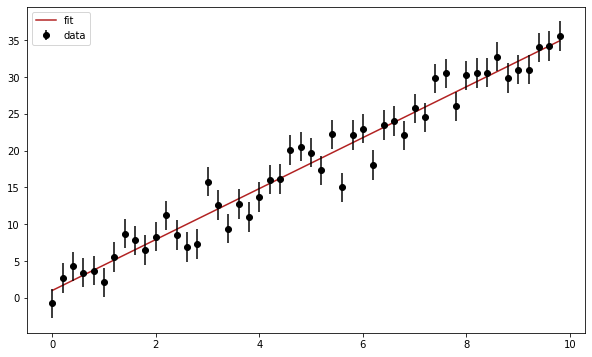

In [116]:
plt.figure(figsize=(10, 6))
mall = np.mean(samples_dynesty[:, 0])
call = np.mean(samples_dynesty[:, 1])

plt.plot(x, straight_line(x, mall, call) , color='firebrick', label='fit')
# plt.plot(x, data, color='k', label='truth')
plt.errorbar(x, data, yerr=sigma, fmt='o', color='k', label='data')
plt.legend()
plt.show()
